In this notebook, we will show how to fit a linear regression model in bayesflow, which is amortized over the number of observations. For this notebook to run, you need to have the latest bayesflow dev version installed,
for example via:

In [1]:
# !pip install git+https://github.com/bayesflow-org/bayesflow.git@dev

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We load a bunch of libraries and choose the keras backend, we want to use.
Here I use JAX but you can freely change that and the notebook will work all the same.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

First, we define our simulator, which in this case consists of a prior and likelihood, as well as of a "meta" simulator that is responsible for simulating
the number of simulations per dataset:

In [9]:
# TODO: do we have to require "batch_shape" to the function passed to meta_fn?
def meta(batch_shape):
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

We can combine these three functions into a bayesflow simulator via:

In [10]:
simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

We passed the `meta` simulator separately to the `meta_fn` argument to make sure
that the number of observations `N` constant within each *batch* of simulated datasets. This is required since, within each batch, the generated datasets need to have the same shape for them to be easily transformable to tensors for deep learning.

Let's see how sampling from the simulator works by sampling a batch of 2 datasets:

In [11]:
# generate a batch of two training samples
# TODO: also allow 2 as an alias of (2,)
sample_data = simulator.sample((2,))
print(sample_data["N"])
print(sample_data["beta"].shape)
print(sample_data["y"].shape)

7
(2, 2)
(2, 7)


To ensure that the training data generated by the simulator can be used for deep learning, we have do a bunch of transformations via `(data_)adapter` objects. Here, I build my own `adapter` from scratch but later on bayesflow will also provide default adapters that will already automate most of the commonly required steps.

In [12]:
# TODO: use the default adapter here as starting point?
adapter = bf.adapters.Adapter()
adapter.to_array()
adapter.broadcast("N")
adapter.convert_dtype(from_dtype="float64", to_dtype="float32")
adapter.as_set(["x", "y"])
adapter.constrain("sigma", lower=0)
adapter.standardize(exclude=["N"])
adapter.concatenate(["beta", "sigma"], into="inference_variables")
adapter.concatenate(["x", "y"], into="summary_variables")
adapter.rename("N", "inference_conditions")

Adapter([ToArray -> Broadcast -> ConvertDType -> AsSet -> Constrain -> Standardize(exclude=['N']) -> Concatenate(['beta', 'sigma'] -> 'inference_variables') -> Concatenate(['x', 'y'] -> 'summary_variables') -> Rename('N' -> 'inference_conditions')])

I want to elaborate on a few adapter steps:

The `.broadcast("N")` transform will copy the value of `N` batch-size times to ensure that it will also have a `batch_size` dimension even though it was actually just a single value, constant over all datasets within a batch.

The `.as_set(["x", "y"])` transform indicates that both `x` and `y` are treated as sets. That is, their values will be treated as *exchangable* such that they will imply the same inference regardless of the values' order. This makes sense, since in linear regression, we can index the observations in arbitrary order and always get the same regression line.

The `.constrain("sigma", lower=0)` transform ensures that the residual standard deviation parameter `sigma` will always be positive. Without this constrain, the neural networks may attempt to predict negative `sigma` which of course would not make much sense.

Standardidazation via `.standardize()` is important for neural networks to learn
reliably without, for example, exploding or vanishing gradients during training. However, we need to exclude the variable `N` from standardization, via `standardize(exclude=["N"])`. This is because `N` is a constant within each batch of training data and can hence not be standardized. In the future, bayesflow will automatically detect this case so that we don't have to manually exclude such constant variables from standardization.

Let's check the shape of our processed data to be passed to the neural networks:

In [13]:
processed_data = adapter(sample_data, batch_size=2)
print(processed_data["summary_variables"].shape)
print(processed_data["inference_conditions"].shape)
print(processed_data["inference_variables"].shape)

(2, 7, 2)
(2, 1)
(2, 3)


Those shapes are as we expect them to be. The first dimenstion is always the batch size which was 2 for our example data. All variables adhere to this rule since the first dimension is indeed 2.

For `summary_variables`, the second dimension is equal to `N`, which happend to be sampled as `14` for these example data. It's third dimension is `2`, since we have combined `x` and `y` into summary variables, each of which are vectors of length `N` within each simulated dataset.

For `inference_conditions`, the second dimension is just `1` because we have passed only the scalar variable `N` there.

For `inference_variables`, the second dimension is `3` because it consists of
`beta` (a vector of length `2`) and `sigma` (a scalar).

We will now define our inference and summary networks. As inference network, we will use a flow matching architecture and as summary network, we will use a deep set. The latter choice is important to reflect that fact that `x` and `y` as supposed to be sets and the deep set architecture ensures they are indeed correctly treated as such.

In [14]:
inference_network = bf.networks.CouplingFlow()
summary_network = bf.networks.DeepSet(depth=2)

We can now define our posterior `approximator` consisting of the two networks and our data adapter from above.

In [15]:
approximator = bf.ContinuousApproximator(
   inference_network=inference_network,
   summary_network=summary_network,
   adapter=adapter,
)

We define some training hyperparameters such as the learning rate and optimization algorithm to apply before compile the approximator with these choices.

In [16]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
approximator.compile(optimizer=optimizer)

Now, we are ready to train our approximator to learn posterior distributions for linear regression models. To achieve this, we will all `approximator.fit` passing the `simulator` and a bunch of hyperparameters that control how long we want to train:

In [17]:
history = approximator.fit(
    epochs=10,
    num_batches=128,
    batch_size=64,
    simulator=simulator,
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - loss: 4.2091 - loss/inference_loss: 4.2091
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 2.3643 - loss/inference_loss: 2.3643
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.6700 - loss/inference_loss: 1.6700
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.1233 - loss/inference_loss: 1.1233
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.8724 - loss/inference_loss: 0.8724
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.7661 - loss/inference_loss: 0.7661
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.5995 - loss/inference_loss: 0.5995
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5500 - loss/inference_loss: 0.5500
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.3564 - loss/inference_loss: 0.3564
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.3912 - loss/inference_loss: 0.3912


The first few steps of training may take a little longer due to network compilation overhead. The total training time for this example is around 2 minutes on a modern laptop.

Let's check out the resulting inference. Say we want to obtain 2000 posterior samples from our approximated posterior of a simulated dataset where we know the ground truth values.

In [46]:
# Set the number of posterior draws you want to get
num_samples = 2000

# Simulate validation data
val_sims = simulator.sample(400)
conditions = {k: v for k, v in val_sims.items() if k != "beta"}

In [62]:
# TODO: shall we allow to sample without a batch dim if batch_size = None or so?
pdraws = approximator.sample(conditions=conditions, batch_size=100, num_samples=num_samples)

C:\Users\Gerald Wong\Documents\Native\Development\bayesflow\bayesflow\utils\numpy_utils.py:40: RuntimeWarning: overflow encountered in exp
  return np.where(beta * x > threshold, x, np.log1p(np.exp(beta * x)) / beta)


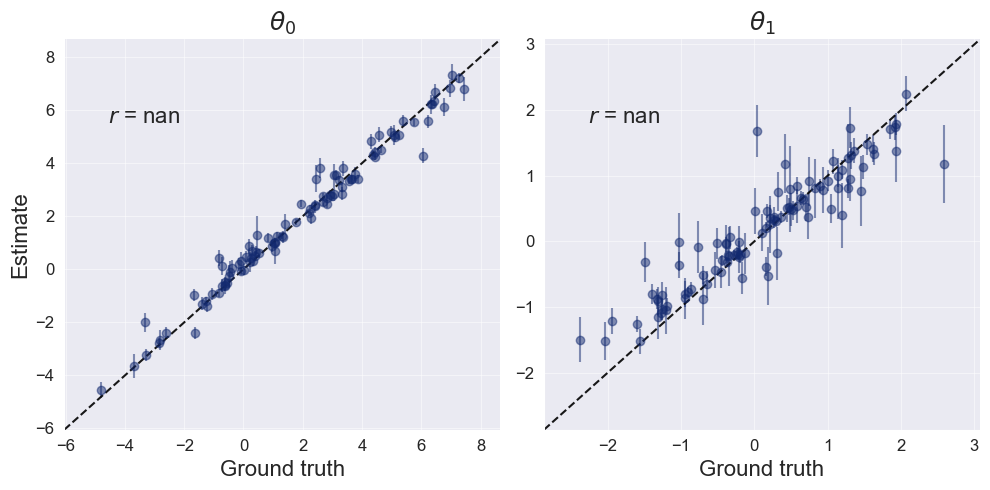

In [63]:
f = bf.diagnostics.plot_recovery(pdraws["beta"], val_sims["beta"])

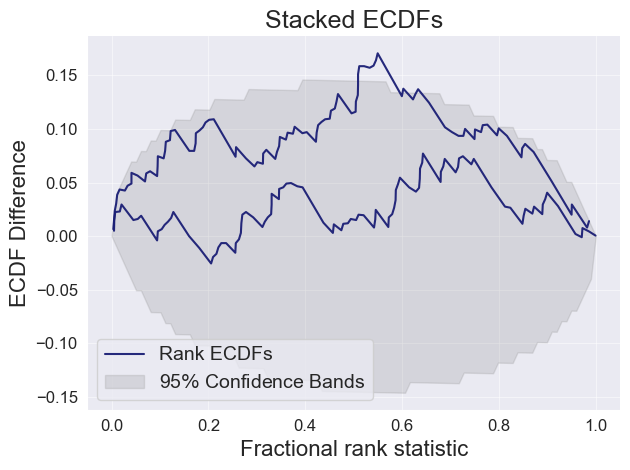

In [67]:
f = bf.diagnostics.plot_sbc_ecdf(pdraws["beta"], val_sims["beta"], difference=True, stacked=True)

Initial sanity checks of the posterior samples look good. `pdraws["beta"]` has shape `(1, 2000, 2)` which makes sense since we asked for inference of a single data set (first dimension is 1), for which we wanted to generated 2000 posterior samples (second dimension is 2000). The third dimension is 2, since the `beta` variable was defined as a vector of length 2 (intercept and slope).
What is more, the minimun posterior sample of `sigma` is positive indicating that our positivity enforcing constraing in the data adapter has indeed worked.

Let's plot the joint posterior distribution of `beta[1]` (the slope) and `sigma`, the residual standard deviation. Based on how we generated this particular dataset, we would expect `beta[1]` to vary around its true value of `1` and `sigma` to vary around its true value of `0.5`. Of course, if this was real data, we wouldn't know the ground truth values, so had no reference to check against. Hence, it is good to first perform some inference on simulated data as a diagnostic for whether the approximator has learned to approximate the true posteriors well enough.

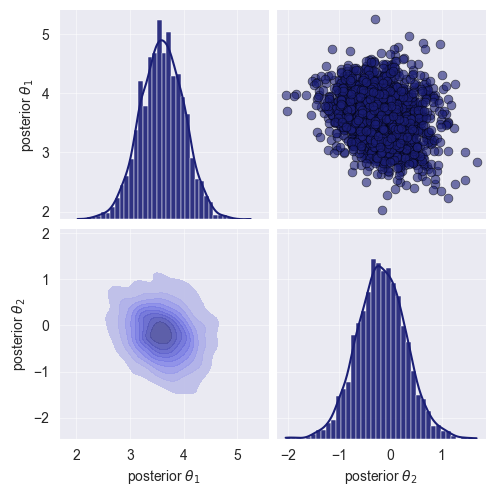

In [68]:
# Prepare figure
f = bf.diagnostics.plot_samples_2d(pdraws["beta"][0], context="posterior")

The plot shows has that indeed, things look as we expected. Likely, for fully accurate posterior inference, we would have to train the approximator a little longer, but that's okay. After all, we can effort a little more training time since afterwards, inference on any number of new (real or simulated) datasets is
very fast due to amortization.

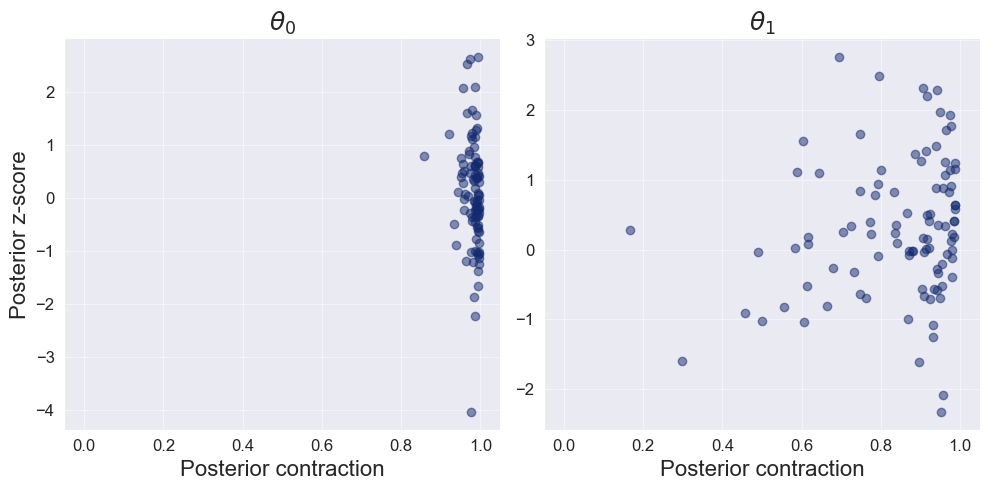

In [69]:
f = bf.diagnostics.plot_z_score_contraction(pdraws["beta"], val_sims["beta"])

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


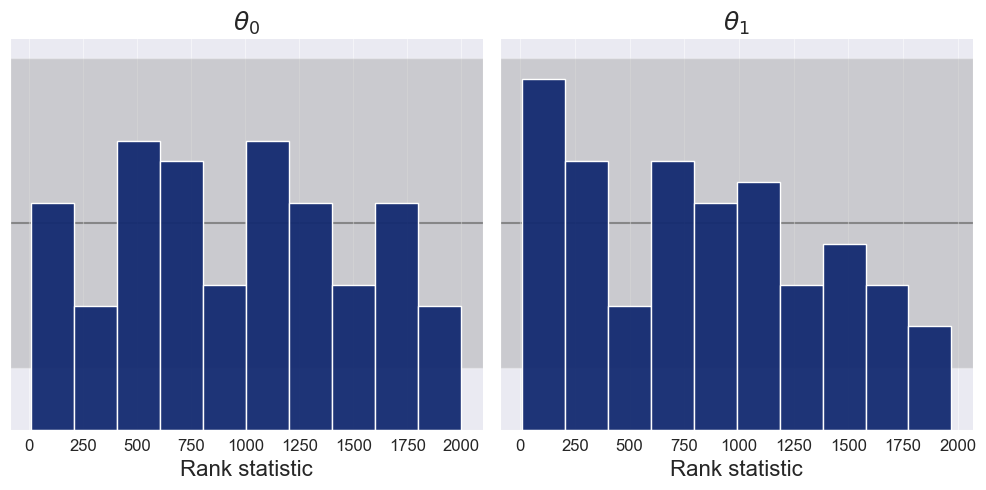

In [70]:
f = bf.diagnostics.plot_sbc_histograms(pdraws["beta"], val_sims["beta"])